In [1]:
import numpy as np
from copy import deepcopy
from math import factorial
from scipy import spatial
from quantum_algorithms import *
from qiskit.circuit.library import CHGate
from qiskit.circuit.library import MCMT

In [2]:
def convert(input_table):
    # input table is a list where each element is a list with 2 elements, converting it to a state vector, e.g. [[1, 2], [3, 4]]
    normalize_factor = 1 / np.sqrt(2 ** len(input_table))
    state_vector = np.zeros(2 ** (len(input_table) * 2), dtype=np.float64)
    non_zero_items = []
    for i in range(2 ** (len(input_table))):
        # get binary representation of i
        i_bin = bin(i)[2:].zfill(len(input_table))
        tmp_string = [-1 for _ in range(len(input_table) * 2)]
        for j in range(len(i_bin)):
            if i_bin[j] == '0':
                index1 = input_table[j][0] - 1
                index2 = input_table[j][1] - 1
                tmp_string[index1] = 0
                tmp_string[index2] = 1
            else:
                index1 = input_table[j][0] - 1
                index2 = input_table[j][1] - 1
                tmp_string[index1] = 1
                tmp_string[index2] = 0
        # get the value of tmp_string
        tmp_string = ''.join([str(i) for i in tmp_string])
        tmp_value = int(tmp_string, 2)
        # count the number of 1s in tmp_string
        count = i_bin.count('1')
        if count % 2 == 0:
            state_vector[tmp_value] = normalize_factor
            non_zero_items.append(tmp_string)
        else:
            state_vector[tmp_value] = -normalize_factor
            non_zero_items.append('-' + tmp_string)
    return state_vector, non_zero_items

In [3]:
def calculate_rank(input_tables):
    table_matrix = np.zeros((len(input_tables), 2 ** (len(input_tables[0]) * 2)), dtype=np.float64)
    for i in range(len(input_tables)):
        table_matrix[i], _ = convert(input_tables[i])
    rank = np.linalg.matrix_rank(table_matrix)
    return rank

In [4]:
def generate_tables(N, current_table):
    if current_table is None:
        current_table = []
    if (2 * len(current_table)) == N:
        vaild_tables.append(current_table)
        return
    remaining_numbers = [i for i in range(1, N + 1)]
    for item in current_table:
        remaining_numbers.remove(item[0])
        remaining_numbers.remove(item[1])
    next_item = [-1, -1]
    next_item[0] = min(remaining_numbers)
    remaining_numbers.remove(next_item[0])
    for number in remaining_numbers:
        next_item[1] = number
        tmp = deepcopy(current_table)
        tmp.append(next_item)
        generate_tables(N, tmp)


In [5]:
def vector_number_in_complete_table(N):
    return int(factorial(N) / (factorial(int(N/2)) * factorial(int(N/2) + 1)))

In [6]:
def generate_complete_set(N):
    if N % 2 != 0:
        raise ValueError('N must be even')
    global vaild_tables
    vaild_tables = []
    generate_tables(N, [])
    complete_set = []
    current_rank = 0
    target_rank = vector_number_in_complete_table(N)
    for table in vaild_tables:
        complete_set.append(table)
        calculated_rank = calculate_rank(complete_set)
        if calculated_rank > current_rank:
            current_rank = calculated_rank
            if current_rank == target_rank:
                return complete_set
        else:
            complete_set.pop()
    return None

In [7]:
def state_vector_to_string(state_vector):
    state_vector = np.round(state_vector, 10)
    # find the minimum abs non-zero value
    min_value = 1
    for i in range(len(state_vector)):
        if state_vector[i] != 0 and abs(state_vector[i]) < min_value:
            min_value = abs(state_vector[i])
    non_zero_items = []
    for i in range(len(state_vector)):
        if state_vector[i] != 0:
            non_zero_items.append((bin(i)[2:].zfill(int(np.log2(len(state_vector)))), state_vector[i]/min_value))
    return non_zero_items

In [8]:
def QGS_supersinglets(input_tables, circuit_return=True, error_rate=1e-4):
    input_matrix = np.zeros((len(input_tables), 2 ** (len(input_tables[0]) * 2)), dtype=np.float64)
    for i in range(len(input_tables)):
        print(input_tables[i])
        input_matrix[i], _ = convert(input_tables[i])
    circuit_set, basis, length = quantum_gram_schmidt(input_matrix, circuit_return=circuit_return, error_rate=error_rate)
    return circuit_set, basis, length
    

In [9]:
def CGS_supersinglets(input_tables):
    input_matrix = np.zeros((len(input_tables), 2 ** (len(input_tables[0]) * 2)), dtype=np.float64)
    for i in range(len(input_tables)):
        input_matrix[i], _ = convert(input_tables[i])
    # use QR decomposition to get the orthogonal matrix
    Q, R = np.linalg.qr(input_matrix.T)
    basis = Q.T
    # basis[i] is |u_i>
    return basis

In [10]:
def correct_answer(N):
    if N % 2 != 0:
        raise ValueError('N must be even')
    # generate the complete set
    complete_set = generate_complete_set(N)
    basis = CGS_supersinglets(complete_set)
    # convert the basis to a string
    basis_string = []
    for i in range(len(basis)):
        basis_string.append(state_vector_to_string(basis[i]))

    return basis, basis_string

In [11]:
_, basis_string = correct_answer(6)
for i in range(len(basis_string)):
    print(f'|u_{i}> = ', end='')
    for item in basis_string[i]:
        if item[1] == 1:
            print(f'+|{item[0]}>', end='')
        elif item[1] == -1:
            print(f'-|{item[0]}>', end='')
        else:
            if item[1] > 0:
                print(f'+{item[1]:.2f}|{item[0]}>', end='')
            else:
                print(f'{item[1]:.2f}|{item[0]}>', end='')
    print()

|u_0> = -|010101>+|010110>+|011001>-|011010>+|100101>-|100110>-|101001>+|101010>
|u_1> = -2.00|010011>+|010101>+|010110>+|011001>+|011010>-2.00|011100>+2.00|100011>-|100101>-|100110>-|101001>-|101010>+2.00|101100>
|u_2> = -2.00|001101>+2.00|001110>+|010101>-|010110>+|011001>-|011010>+|100101>-|100110>+|101001>-|101010>-2.00|110001>+2.00|110010>
|u_3> = -4.00|001011>+2.00|001101>+2.00|001110>+2.00|010011>-|010101>-|010110>+|011001>+|011010>-2.00|011100>+2.00|100011>-|100101>-|100110>+|101001>+|101010>-2.00|101100>-2.00|110001>-2.00|110010>+4.00|110100>
|u_4> = -3.00|000111>+|001011>+|001101>+|001110>+|010011>+|010101>+|010110>-|011001>-|011010>-|011100>+|100011>+|100101>+|100110>-|101001>-|101010>-|101100>-|110001>-|110010>-|110100>+3.00|111000>


In [12]:
def trival_construction(N):
    # suppose we have state tomography technique, we perform orthogonalization immediately
    table = generate_complete_set(N)
    # print(table)
    circuit_set, basis, length = QGS_supersinglets(table)
    print('the number of generated basis is ', length)
    print('the number of a complete set is ', vector_number_in_complete_table(N))

    print('for super singlets:')

    print(state_vector_to_string(basis[0]))
    print(state_vector_to_string(basis[1]))
    print(state_vector_to_string(basis[2]))
    print(state_vector_to_string(basis[3]))
    

trival_construction(6)

[[1, 2], [3, 4], [5, 6]]
[[1, 2], [3, 5], [4, 6]]
[[1, 3], [2, 4], [5, 6]]
[[1, 3], [2, 5], [4, 6]]
[[1, 4], [2, 5], [3, 6]]
count=2
count=2
count=2
count=3
the number of generated basis is  5
the number of a complete set is  5
for super singlets:
[('010101', (1+0j)), ('010110', (-1+0j)), ('011001', (-1+0j)), ('011010', (1+0j)), ('100101', (-1+0j)), ('100110', (1+0j)), ('101001', (1+0j)), ('101010', (-1+0j))]
[('010011', (2.000000000489898-0j)), ('010101', (-1+0j)), ('010110', (-1+0j)), ('011001', (-1+0j)), ('011010', (-1+0j)), ('011100', (2.000000000489898-0j)), ('100011', (-2.000000000489898+0j)), ('100101', (1-0j)), ('100110', (1+0j)), ('101001', (1+0j)), ('101010', (1-0j)), ('101100', (-2.000000000489898+0j))]
[('001101', (2.000000000489898-0j)), ('001110', (-2.000000000489898+0j)), ('010101', (-1+0j)), ('010110', (1-0j)), ('011001', (-1+0j)), ('011010', (1+0j)), ('100101', (-1+0j)), ('100110', (1+0j)), ('101001', (-1+0j)), ('101010', (1-0j)), ('110001', (2.000000000489898-0j)), ('

In [13]:
def from_m_to_m_plus_one(qc, input_state, k):
    """
    construct a_{k+1}^(m+1) from a_{k+1}^(m)
    """
    total_qubit_number = qc.num_qubits
    running_times = 0
    # reverse the order of input_state
    while True:
        tmp_qc = QuantumCircuit(total_qubit_number)
        tmp_qc.initialize(input_state, range(k, total_qubit_number))
        tmp_qc = tmp_qc.compose(qc, range(total_qubit_number), inplace=False)
        simulator = Aer.get_backend('statevector_simulator')
        job = execute(tmp_qc, simulator, shots=1)
        result = job.result()
        running_times += 1
        target_result = '0' * k
        if target_result in result.get_counts().keys():
            #print(result.get_counts())
            statevector = np.asarray(result.get_statevector())
            # print(state_vector_to_string(statevector))
            reduced_state_vector = np.zeros(len(input_state), dtype=complex)
            for i in range(len(input_state)):
                reduced_state_vector[i] = statevector[i* 2 ** (k)]
            return reduced_state_vector, running_times
            
    

In [14]:
def construct_oracle_for_table(current_table, ancilla_number, control_qubit=-1):
    """
    construct the oracle for the table, the oracle is a quantum circuit
    current_table: the current table, a list of tuples, e.g. [(1, 2), (3, 4)]
    ancilla_number: the number of ancilla qubits
    return: the oracle circuit
    """
    # get the number of qubits in the circuit
    if control_qubit < 0:
        qubit_number = len(current_table) * 2 + ancilla_number
    else:
        qubit_number = len(current_table) * 2 + ancilla_number
    #print('the number of qubits in the circuit is ', qubit_number)
    oracle = QuantumCircuit(qubit_number)
    system_qubit_number = 2 * len(current_table)
    # apply CNOT gates to all pairs in the table
    if control_qubit == -1:
        for i in range(len(current_table)):
            oracle.h(system_qubit_number - current_table[i][0] + ancilla_number)
            oracle.x(system_qubit_number - current_table[i][1] + ancilla_number)
            oracle.cx(system_qubit_number - current_table[i][0]+ancilla_number, system_qubit_number - current_table[i][1]+ancilla_number)
            oracle.z(system_qubit_number - current_table[i][1] + ancilla_number)
        return oracle
    else:
        for i in range(len(current_table)):
            oracle.append(CHGate(), [control_qubit, system_qubit_number - current_table[i][0]+ancilla_number])
            oracle.cx(control_qubit, system_qubit_number - current_table[i][1] + ancilla_number)
            oracle.ccx(control_qubit, system_qubit_number - current_table[i][0]+ancilla_number, system_qubit_number - current_table[i][1]+ancilla_number)
            oracle.cz(control_qubit, system_qubit_number - current_table[i][1] + ancilla_number)
            oracle.barrier()
        return oracle


In [19]:
def construct_u_k_plus_one(previous_bases, a_k_plus_one, system_size, error_rate=1e-10, fix_iter=10, choose=1):
    """previous_bases[i] and a_k_plus_one are all like [[1,2],[3,4]]"""
    k = len(previous_bases)
    #print(f'constructing U_{k+1} from previous bases and a_{k+1}')
    #print(f'the k+1 th table is {a_k_plus_one}')
    correct_states, _ = correct_answer(system_size)
    qc = QuantumCircuit(k+system_size, k)
    initial_input_state, _ = convert(a_k_plus_one)
    
    for i in range(0,k):
        qc.h(i)
        tmp_circuit = construct_oracle_for_table(previous_bases[i], k, i)
        qc = qc.compose(tmp_circuit.inverse(), qubits=range(k + system_size))

        qc.barrier()
        for j in range(k, k+ system_size):
            qc.x(j)

    
        mcz = MCMT('cz', system_size, 1)
        applied_qubits = [i] + [j for j in range(k, k + system_size)]
        qc = qc.compose(mcz, qubits=applied_qubits)

        for j in range(k, k + system_size):
            qc.x(j)

        qc.barrier()

        qc = qc.compose(tmp_circuit, qubits=range(k + system_size))
        qc.h(i)
        qc.barrier()

    for i in range(0, k):
        qc.measure(i, i)

    current_input_state = initial_input_state
    total_running_number = 0 # how many times the qc needed to be run?
    total_running_times = 0  # how many m needed?
    infidelities = [1 - np.abs(np.dot(current_input_state, correct_states[k]))**2]
    if choose == 1:
        while True:
            current_output_state, running_number = from_m_to_m_plus_one(qc, current_input_state, k)
            total_running_number = running_number * (total_running_number + 1)
            current_infidelity = 1 - np.abs(np.dot(current_output_state, correct_states[k]))**2
            infidelities.append(current_infidelity)
            total_running_times += 1
            if current_infidelity < error_rate:
                break
            else:
                #print('infidelity is ', current_infidelity)
                #print(f'current state is {state_vector_to_string(current_output_state)}')
                #print(f'correct state is {state_vector_to_string(correct_states[k])}')
                current_input_state = current_output_state
    elif choose == 2:
        for i in range(fix_iter):
            current_output_state, running_number = from_m_to_m_plus_one(qc, current_input_state, k)
            total_running_number = running_number * (total_running_number + 1)
            current_infidelity = 1 - np.abs(np.dot(current_output_state, correct_states[k]))**2
            infidelities.append(current_infidelity)
            total_running_times += 1
            #print(f'iteration {i+1}, infidelity is ', current_infidelity)
            #print(f'current state is {state_vector_to_string(current_output_state)}')
            #print(f'correct state is {state_vector_to_string(correct_states[k])}')
            current_input_state = current_output_state
    else:
        raise ValueError('choose must be 1 or 2')
    info_output = (k+1, error_rate, total_running_times, total_running_number, infidelities)
    return current_output_state, qc, info_output        
        


In [259]:
tables = [[[1,2],[3,4],[5,6]], [[1,2],[3,5],[4,6]], [[1,3],[2,4],[5,6]]]
correct_states, _ = correct_answer(6)
#print('current correct answer is', correct_states[2])
current_projector = np.eye(2 ** (len(tables[0]) * 2), dtype=np.float64)
for j in range(1, -1,-1):
    tmp, _ = convert(tables[j])
    current_projector = np.dot(current_projector, np.eye(2 ** (len(tables[0]) * 2), dtype=np.float64) - np.outer(tmp, np.conjugate(tmp)))

projected = np.dot(current_projector, convert(tables[2])[0])
projected = projected / np.linalg.norm(projected)
print('projected state is ', projected)
construct_u_k_plus_one(tables[:2], [[1,3],[2,4],[5,6]], 6)

projected state is  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.08248290e-01 -4.08248290e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.65107192e-17
  0.00000000e+00 -2.04124145e-01  2.04124145e-01  0.00000000e+00
  0.00000000e+00 -2.04124145e-01  2.04124145e-01  0.00000000e+00
 -1.65107192e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.65107192e-17
  0.00000000e+00 -2.04124145e-01  2.04124145e-01  0.00000000e+00
  0.00000000e+00 -2.04124145e-01  2.04124145e-01  0.00000000e+00
  1.65107192e-17  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.08248290e-01 -4.08248290e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.0

(array([ 2.16674460e-33-1.88701826e-33j, -4.95394060e-17+3.20493781e-17j,
         5.52049892e-17-5.60864117e-17j,  4.12433747e-34+2.65361942e-33j,
         5.47875944e-18-1.60246891e-17j,  2.69535281e-17+2.26623326e-17j,
        -3.89373504e-17+2.27843971e-33j, -1.44631644e-17+2.40370336e-17j,
        -1.81275782e-19+2.26623326e-17j,  2.81844934e-17+1.13311663e-17j,
        -2.57244200e-17+7.86257607e-34j,  3.50009755e-18-2.26623326e-17j,
        -5.69694872e-17+2.34063080e-32j,  4.08248290e-01-1.90429889e-16j,
        -4.08248290e-01+2.46226972e-16j, -5.27104102e-18+1.81039782e-33j,
         1.27965052e-17-5.66558315e-18j,  1.77483243e-17+1.44519998e-33j,
         3.50836433e-19+4.46404568e-33j, -1.68026774e-17-3.39934989e-17j,
         1.68427043e-34+2.51602434e-33j, -2.04124145e-01+1.70562760e-17j,
         2.04124145e-01-3.53182230e-17j, -2.71572158e-33+9.04196248e-34j,
         5.69694872e-17-5.75137860e-33j, -2.04124145e-01-6.44635205e-17j,
         2.04124145e-01+7.51455190e-18

In [16]:
def nontrival_construction_1(N, error_rate=1e-10):
    # iterate till convergence
    table = generate_complete_set(N)
    results = []
    qcs = []
    infos = []
    first_state, _ = convert(table[0])
    results.append(first_state)
    infos.append((1,error_rate, 1, 1))
    qcs.append(construct_oracle_for_table(table[0], 0))
    for i in range(1, len(table)):
        current_state, qc, current_info = construct_u_k_plus_one(table[:i], table[i], system_size=N, error_rate=error_rate, choose=1)
        results.append(current_state)
        qcs.append(qc)
        infos.append(current_info)
    
    return qcs, results, infos


In [17]:
def nontrival_construction_2(N):
    # fix iteration number
    table = generate_complete_set(N)
    results = []
    qcs = []
    infos = []
    first_state, _ = convert(table[0])
    results.append(first_state)
    infos.append((1,1e-10, 1, 1))
    qcs.append(construct_oracle_for_table(table[0], 0))
    for i in range(1, len(table)):
        current_state, qc, current_info = construct_u_k_plus_one(table[:i], table[i], system_size=N, error_rate=1e-10, fix_iter=20, choose=2)
        results.append(current_state)
        qcs.append(qc)
        infos.append(current_info)
    
    return qcs, results, infos

In [22]:
qcs, results, infos = nontrival_construction_1(6, 1e-6)
print('index, error_rate, total_running_times_of_m, total_running_number_of_qc, final_infidelity')
print(infos)

index, error_rate, total_running_times_of_m, total_running_number_of_qc, final_infidelity
[(1, 1e-06, 1, 1), (2, 1e-06, 1, 1, [0.2500000000000001, 2.220446049250313e-16]), (3, 1e-06, 1, 1, [0.2500000000000001, -4.440892098500626e-16]), (4, 1e-06, 7, 9, [0.4375, 0.21632653061224505, 0.032745591939546514, 0.0035073492143939955, 0.0003304978314255802, 2.9006752374383105e-05, 2.4239163451955648e-06, 1.9526726169338815e-07]), (5, 1e-06, 10, 10, [0.5000000000000001, 0.24567219152854525, 0.00890866044479377, 0.0013436829780461013, 0.000632866566287249, 0.00022800916711374075, 7.037324716474558e-05, 2.0260898503599023e-05, 5.649841727461968e-06, 1.552048328079536e-06, 4.233354919946919e-07])]


In [462]:
error_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
record_running_numbers = [[0 for j in range(15)] for _ in range(5)]
for j in range(10):
    for k in range(len(error_rates)):
        current_error_rate = error_rates[k]
        print(f'current error rate is {current_error_rate}')
        qcs, results, infos = nontrival_construction_1(6, current_error_rate)
        for i in range(len(infos)):
            record_running_numbers[i][k] += infos[i][3]

for i in range(len(record_running_numbers)):
    for j in range(len(record_running_numbers[i])):
        record_running_numbers[i][j] /= 10
print('average running numbers for each error rate:')
for i in range(len(record_running_numbers)):
    print(f'for {i+1}th basis, the average running numbers are {record_running_numbers[i]}')

current error rate is 0.1
current error rate is 0.01
current error rate is 0.001
current error rate is 0.0001
current error rate is 1e-05
current error rate is 1e-06
current error rate is 1e-07
current error rate is 1e-08
current error rate is 1e-09
current error rate is 1e-10
current error rate is 1e-11
current error rate is 1e-12
current error rate is 1e-13
current error rate is 1e-14
current error rate is 1e-15
current error rate is 0.1
current error rate is 0.01
current error rate is 0.001
current error rate is 0.0001
current error rate is 1e-05
current error rate is 1e-06
current error rate is 1e-07
current error rate is 1e-08
current error rate is 1e-09
current error rate is 1e-10
current error rate is 1e-11
current error rate is 1e-12
current error rate is 1e-13
current error rate is 1e-14
current error rate is 1e-15
current error rate is 0.1
current error rate is 0.01
current error rate is 0.001
current error rate is 0.0001
current error rate is 1e-05
current error rate is 1e-0

In [458]:
for i in range(len(record_running_numbers)):
    print(f'for {i+1}th table, the running numbers are {record_running_numbers[i]}')

for 1th table, the running numbers are [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
for 2th table, the running numbers are [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]
for 3th table, the running numbers are [1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1]
for 4th table, the running numbers are [4, 4, 5, 5, 6, 11, 8, 9, 12, 11, 11, 12, 13, 14, 15]
for 5th table, the running numbers are [4, 2, 4, 6, 8, 16, 13, 13, 15, 17, 19, 20, 22, 24, 27]


In [307]:
qcs, states, infos = nontrival_construction(8)

constructing U_2 from previous bases and a_2
the k+1 th table is [[1, 2], [3, 4], [5, 7], [6, 8]]
constructing U_3 from previous bases and a_3
the k+1 th table is [[1, 2], [3, 5], [4, 6], [7, 8]]
constructing U_4 from previous bases and a_4
the k+1 th table is [[1, 2], [3, 5], [4, 7], [6, 8]]
insimilarity is  0.1147466637240191
insimilarity is  0.01650907067708407
insimilarity is  0.001755214997040011
insimilarity is  0.00016526257157167823
constructing U_5 from previous bases and a_5
the k+1 th table is [[1, 2], [3, 6], [4, 7], [5, 8]]
insimilarity is  0.13147952904295068
insimilarity is  0.004464295188160383
insimilarity is  0.0006720673262684551
insimilarity is  0.0003164833640032505
insimilarity is  0.00011401108282038663
constructing U_6 from previous bases and a_6
the k+1 th table is [[1, 3], [2, 4], [5, 6], [7, 8]]
constructing U_7 from previous bases and a_7
the k+1 th table is [[1, 3], [2, 4], [5, 7], [6, 8]]
insimilarity is  0.09093262972451743
insimilarity is  0.014081464353

In [308]:
for i in range(len(qcs)):
    print(f'info {i} is {infos[i]}')

info 0 is (1, 0.0001, 1, 1)
info 1 is (2, 0.0001, 1, 1)
info 2 is (3, 0.0001, 1, 1)
info 3 is (4, 0.0001, 5, 7)
info 4 is (5, 0.0001, 6, 10)
info 5 is (6, 0.0001, 1, 1)
info 6 is (7, 0.0001, 8, 9)
info 7 is (8, 0.0001, 7, 9)
info 8 is (9, 0.0001, 13, 20)
info 9 is (10, 0.0001, 11, 19)
info 10 is (11, 0.0001, 5, 7)
info 11 is (12, 0.0001, 16, 16)
info 12 is (13, 0.0001, 11, 12)
info 13 is (14, 0.0001, 31, 32)


In [37]:
qcs, states, infos = nontrival_construction_2(6)

In [38]:
orthogonal_check = np.dot(states, np.conjugate(np.transpose(states)))
print('the orthogonal check matrix is ')
print(orthogonal_check)

the orthogonal check matrix is 
[[ 1.00000000e+00+0.00000000e+00j  1.36646305e-18+1.47774660e-18j
   2.00063548e-17-3.92162027e-17j -1.45519188e-11-7.41298774e-19j
   5.90591629e-07-4.45482503e-17j]
 [ 1.36646305e-18-1.47774660e-18j  1.00000000e+00+0.00000000e+00j
   2.23597361e-17-1.71812816e-17j  5.25190689e-13-1.35484602e-16j
  -3.40979350e-07-5.34322993e-17j]
 [ 2.00063548e-17+3.92162027e-17j  2.23597361e-17+1.71812816e-17j
   1.00000000e+00+0.00000000e+00j  8.40162796e-12-4.09577253e-16j
  -5.77277085e-07+3.65346468e-16j]
 [-1.45519188e-11+7.41298774e-19j  5.25190689e-13+1.35484602e-16j
   8.40162796e-12+4.09577253e-16j  1.00000000e+00+0.00000000e+00j
   3.33291724e-07+1.49046003e-16j]
 [ 5.90591629e-07+4.45482503e-17j -3.40979350e-07+5.34322993e-17j
  -5.77277085e-07-3.65346468e-16j  3.33291724e-07-1.49046003e-16j
   1.00000000e+00+0.00000000e+00j]]


In [39]:
for item in states:
    print(state_vector_to_string(item))

[('010101', 1.0), ('010110', -1.0), ('011001', -1.0), ('011010', 1.0), ('100101', -1.0), ('100110', 1.0), ('101001', 1.0), ('101010', -1.0)]
[('010011', (2.000000000489898-0j)), ('010101', (-1+0j)), ('010110', (-1+0j)), ('011001', (-1+0j)), ('011010', (-1+0j)), ('011100', (2.000000000489898-0j)), ('100011', (-2.000000000489898+0j)), ('100101', (1-0j)), ('100110', (1-0j)), ('101001', (1-0j)), ('101010', (1+0j)), ('101100', (-2.000000000489898+0j))]
[('001101', (2.000000000489898-0j)), ('001110', (-2.000000000489898+0j)), ('010101', (-1+0j)), ('010110', (1-0j)), ('011001', (-1+0j)), ('011010', (1-0j)), ('100101', (-1+0j)), ('100110', (1-0j)), ('101001', (-1+0j)), ('101010', (1+0j)), ('110001', (2.000000000489898-0j)), ('110010', (-2.000000000489898+0j))]
[('001011', (4-0j)), ('001101', (-2+0j)), ('001110', (-2+0j)), ('010011', (-2+0j)), ('010101', (1-0j)), ('010110', (1-0j)), ('011001', (-1+0j)), ('011010', (-1+0j)), ('011100', (2-0j)), ('100011', (-2+0j)), ('100101', (1-0j)), ('100110',

In [41]:
correct_states, _ = correct_answer(6)
for i in range(len(states)):
    print(f'similarity between state {i} and correct state is ', np.abs(np.dot(states[i], correct_states[i])))

similarity between state 0 and correct state is  1.0
similarity between state 1 and correct state is  1.0
similarity between state 2 and correct state is  1.0000000000000002
similarity between state 3 and correct state is  1.0
similarity between state 4 and correct state is  0.9999999999995455


In [46]:
tmp = qcs[4].reverse_bits()
tmp.draw(output='mpl')
from qiskit.visualization import circuit_drawer
fig = circuit_drawer(tmp, output='mpl', fold=60)
fig.savefig(f'qcs4_for_6_alter.pdf', bbox_inches='tight')

In [35]:
tmp = qcs[1].reverse_bits()
tmp.draw(output='mpl')
from qiskit.visualization import circuit_drawer
fig = circuit_drawer(tmp, output='mpl', fold=60)
fig.savefig(f'qcs1_for_4_alter.pdf', bbox_inches='tight')

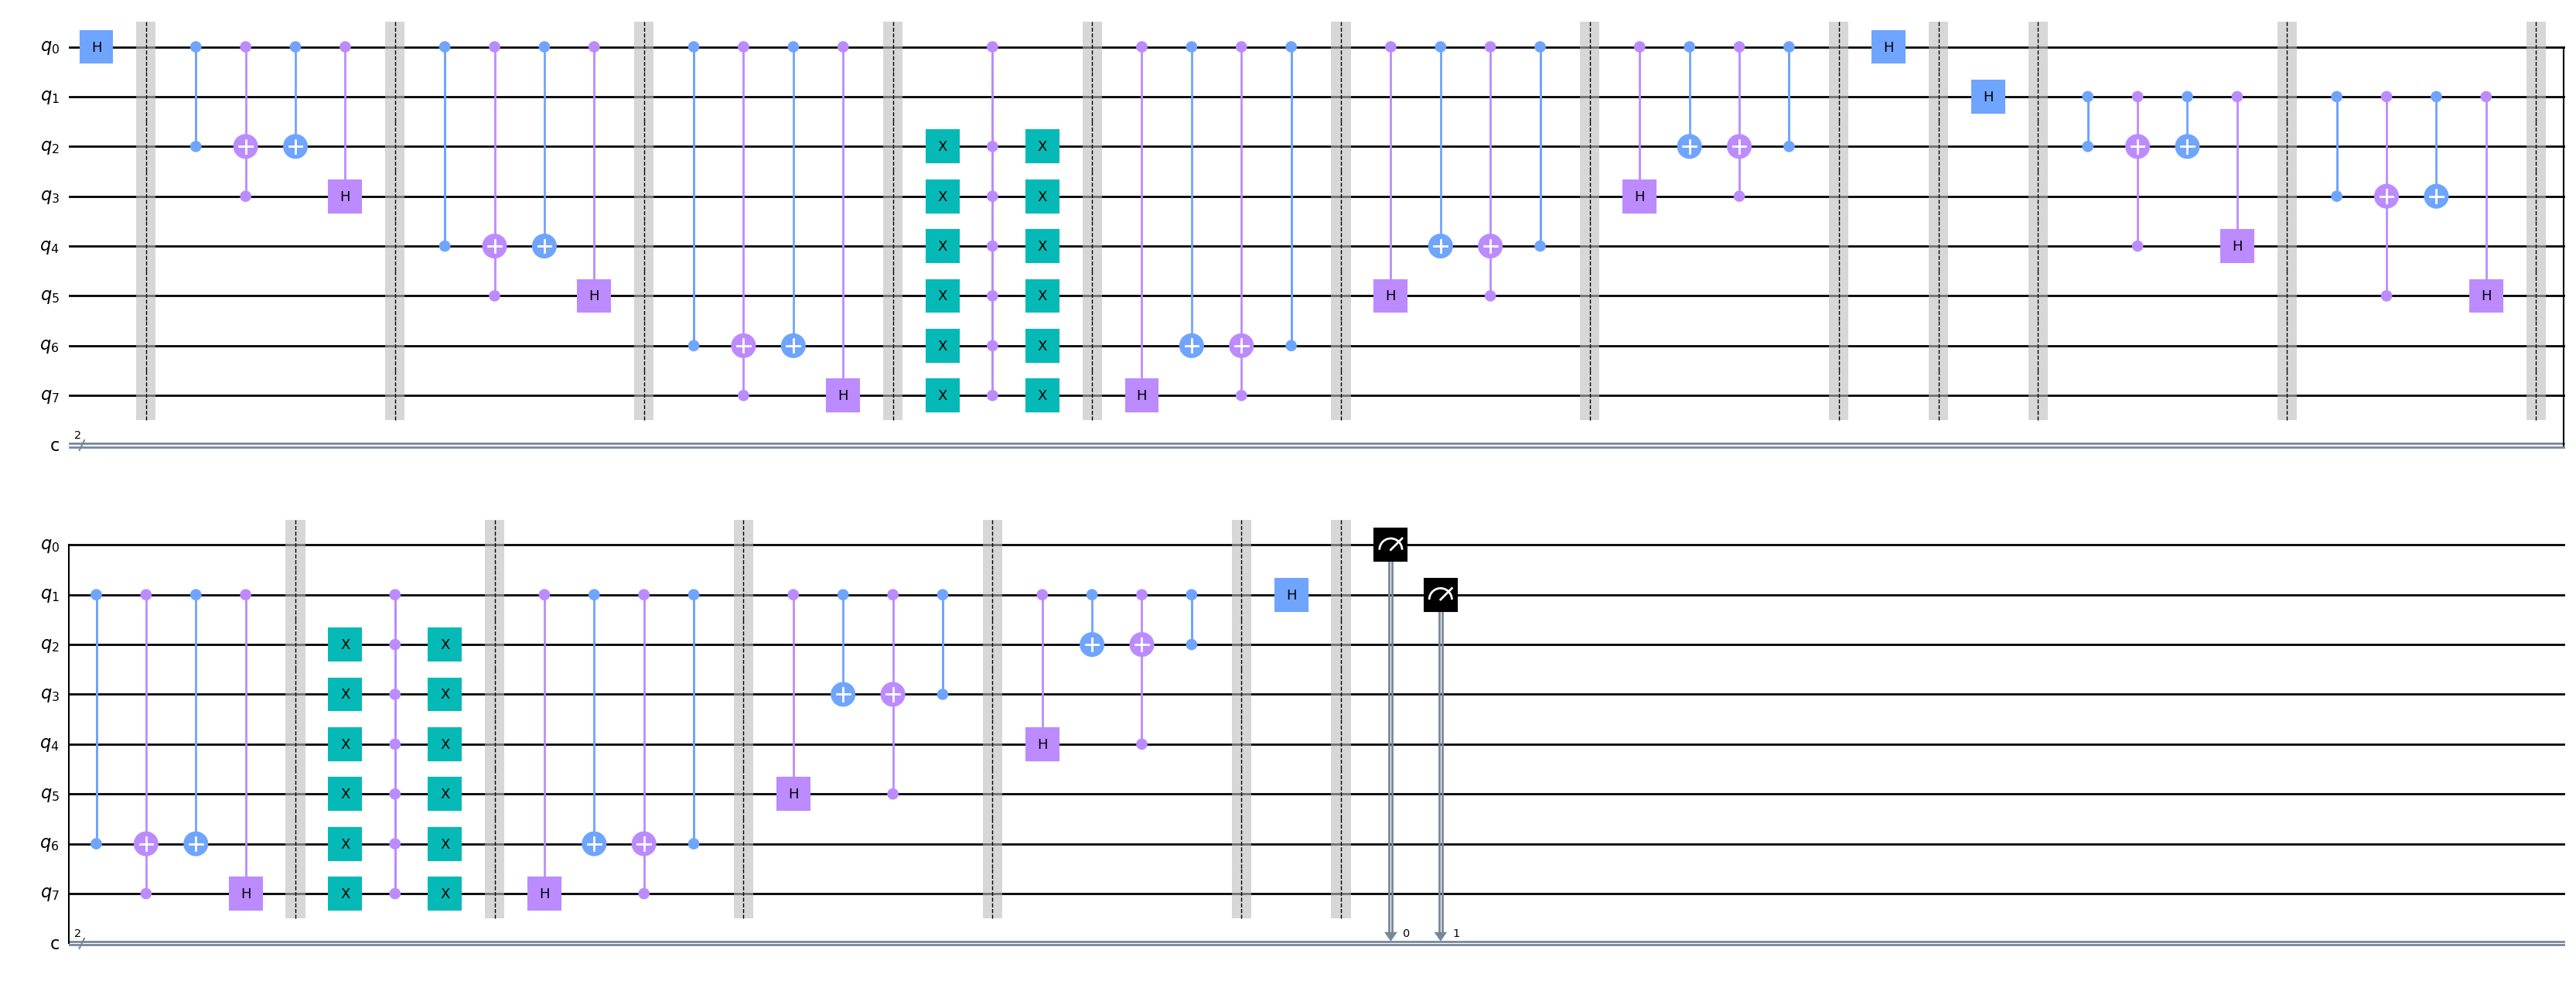

In [53]:
qcs[2].draw(output='mpl', fold=50)

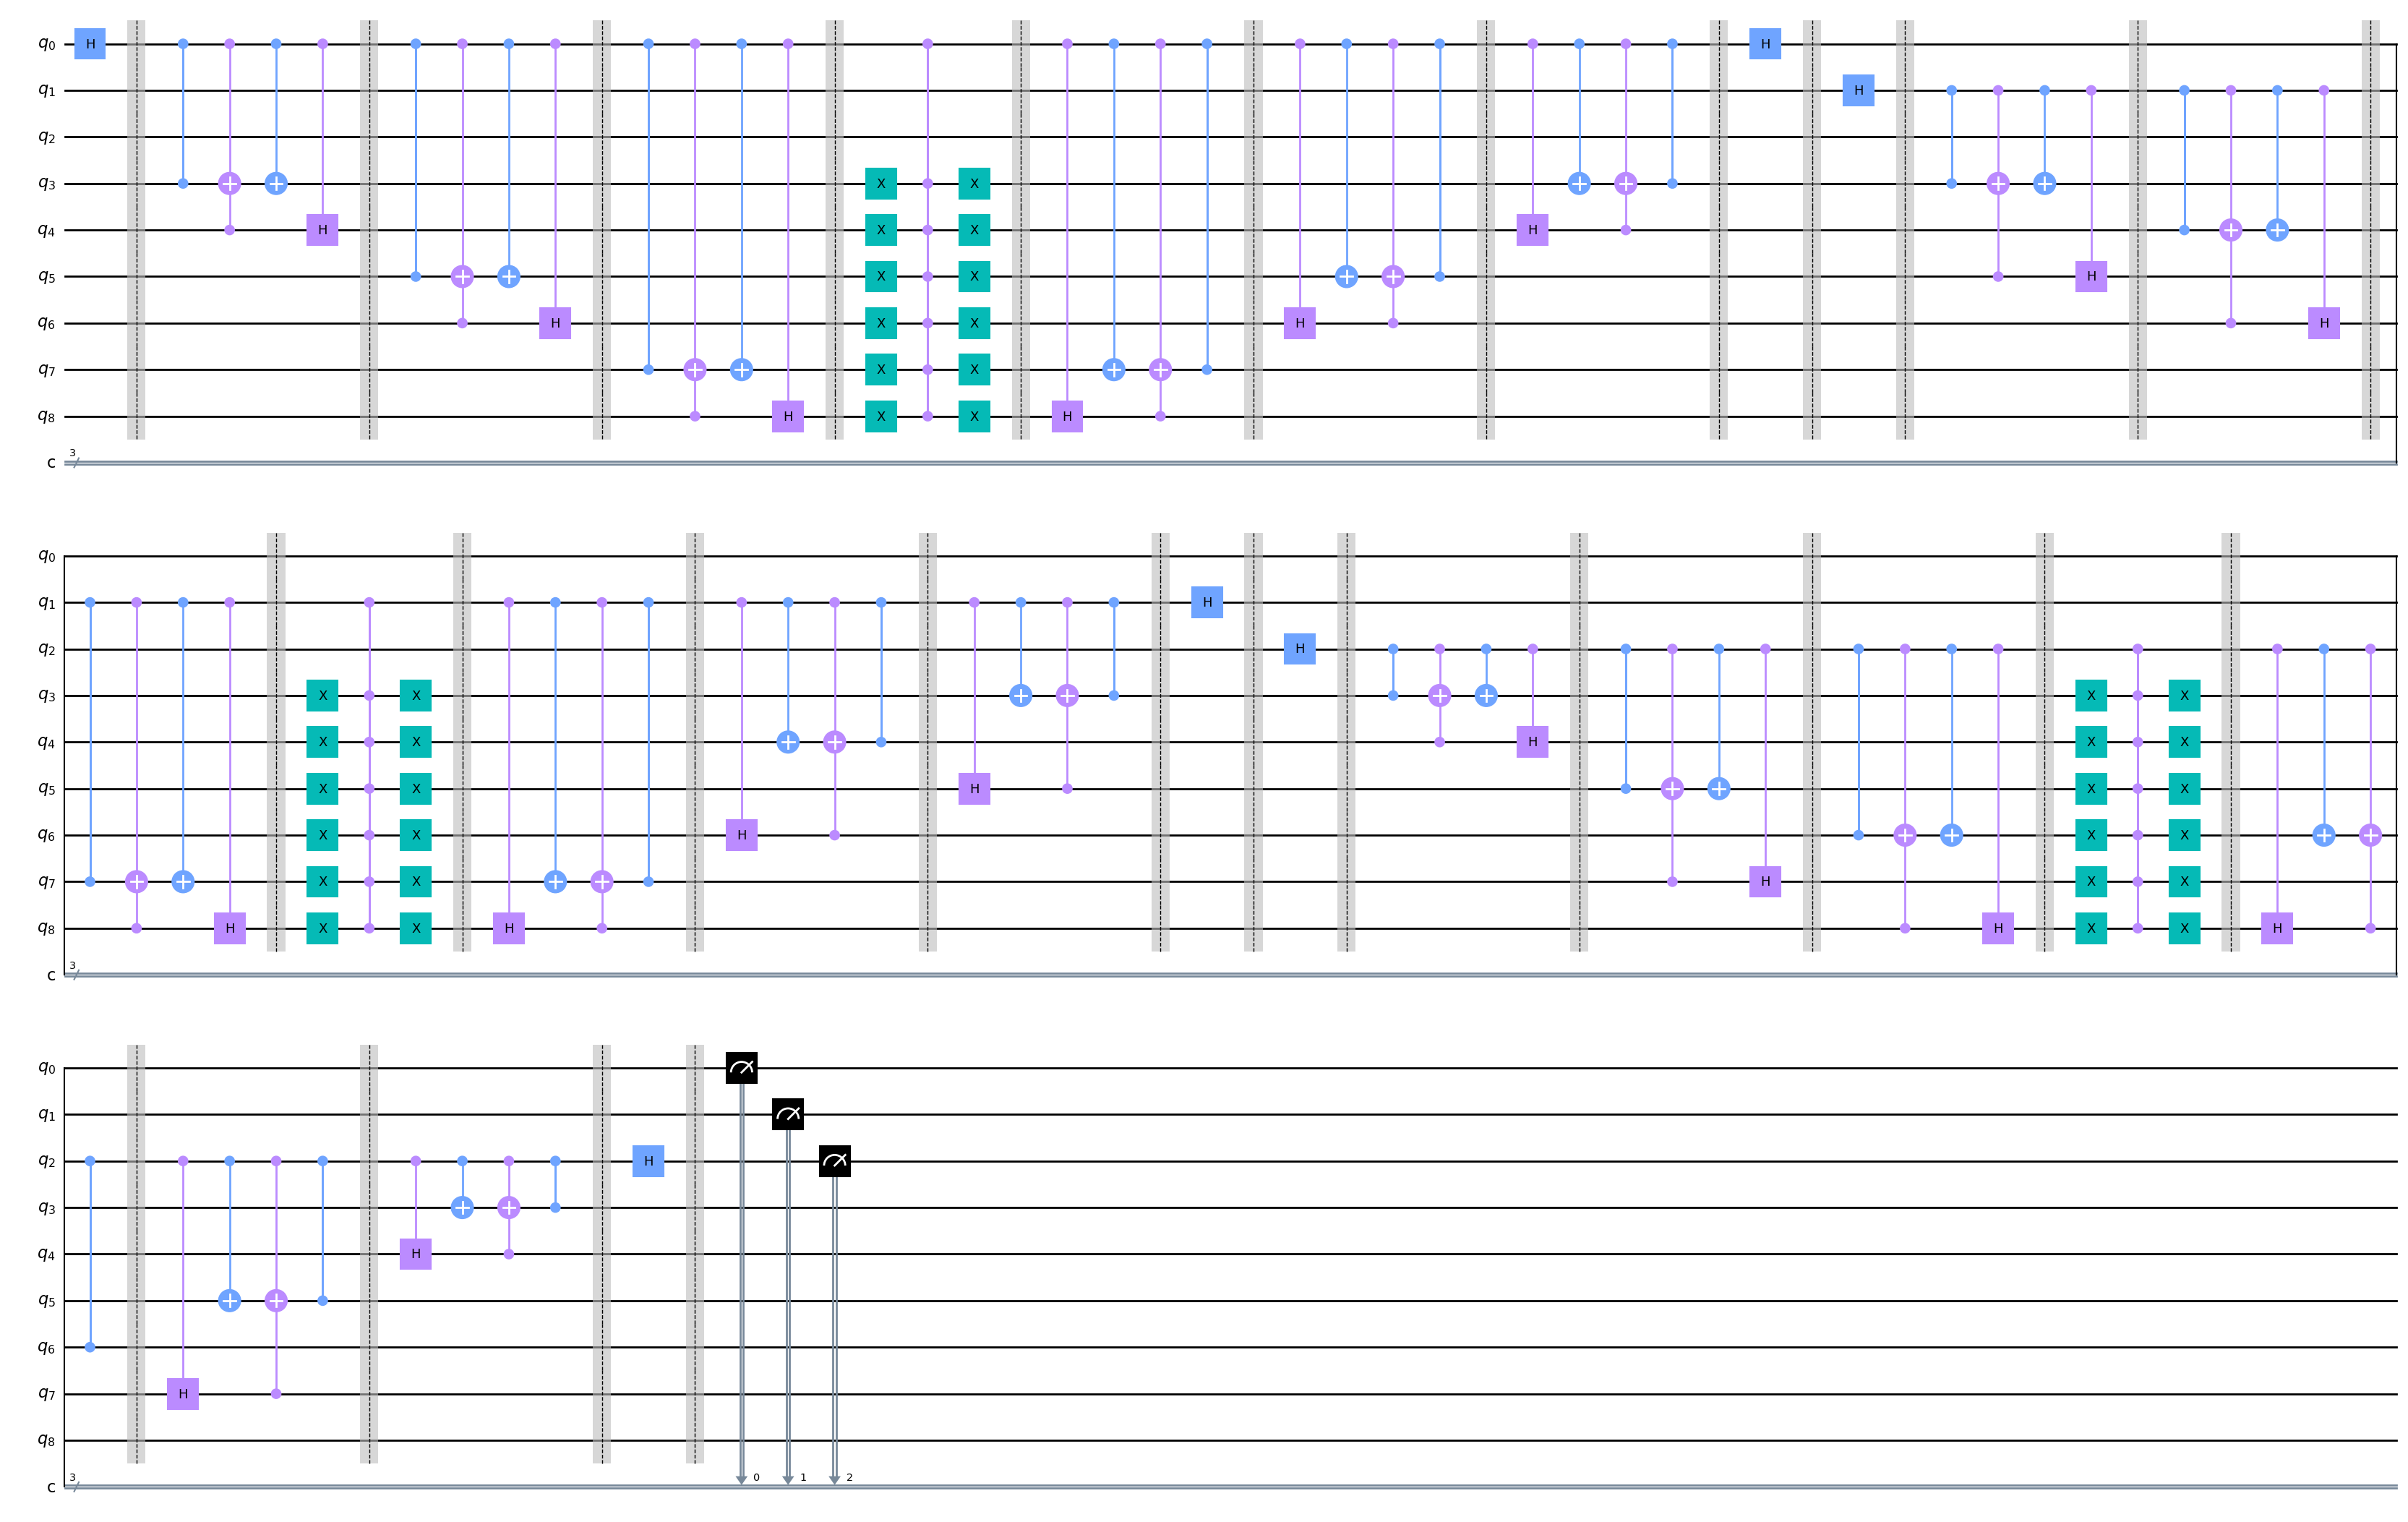

In [54]:
qcs[3].draw(output='mpl', fold=50)

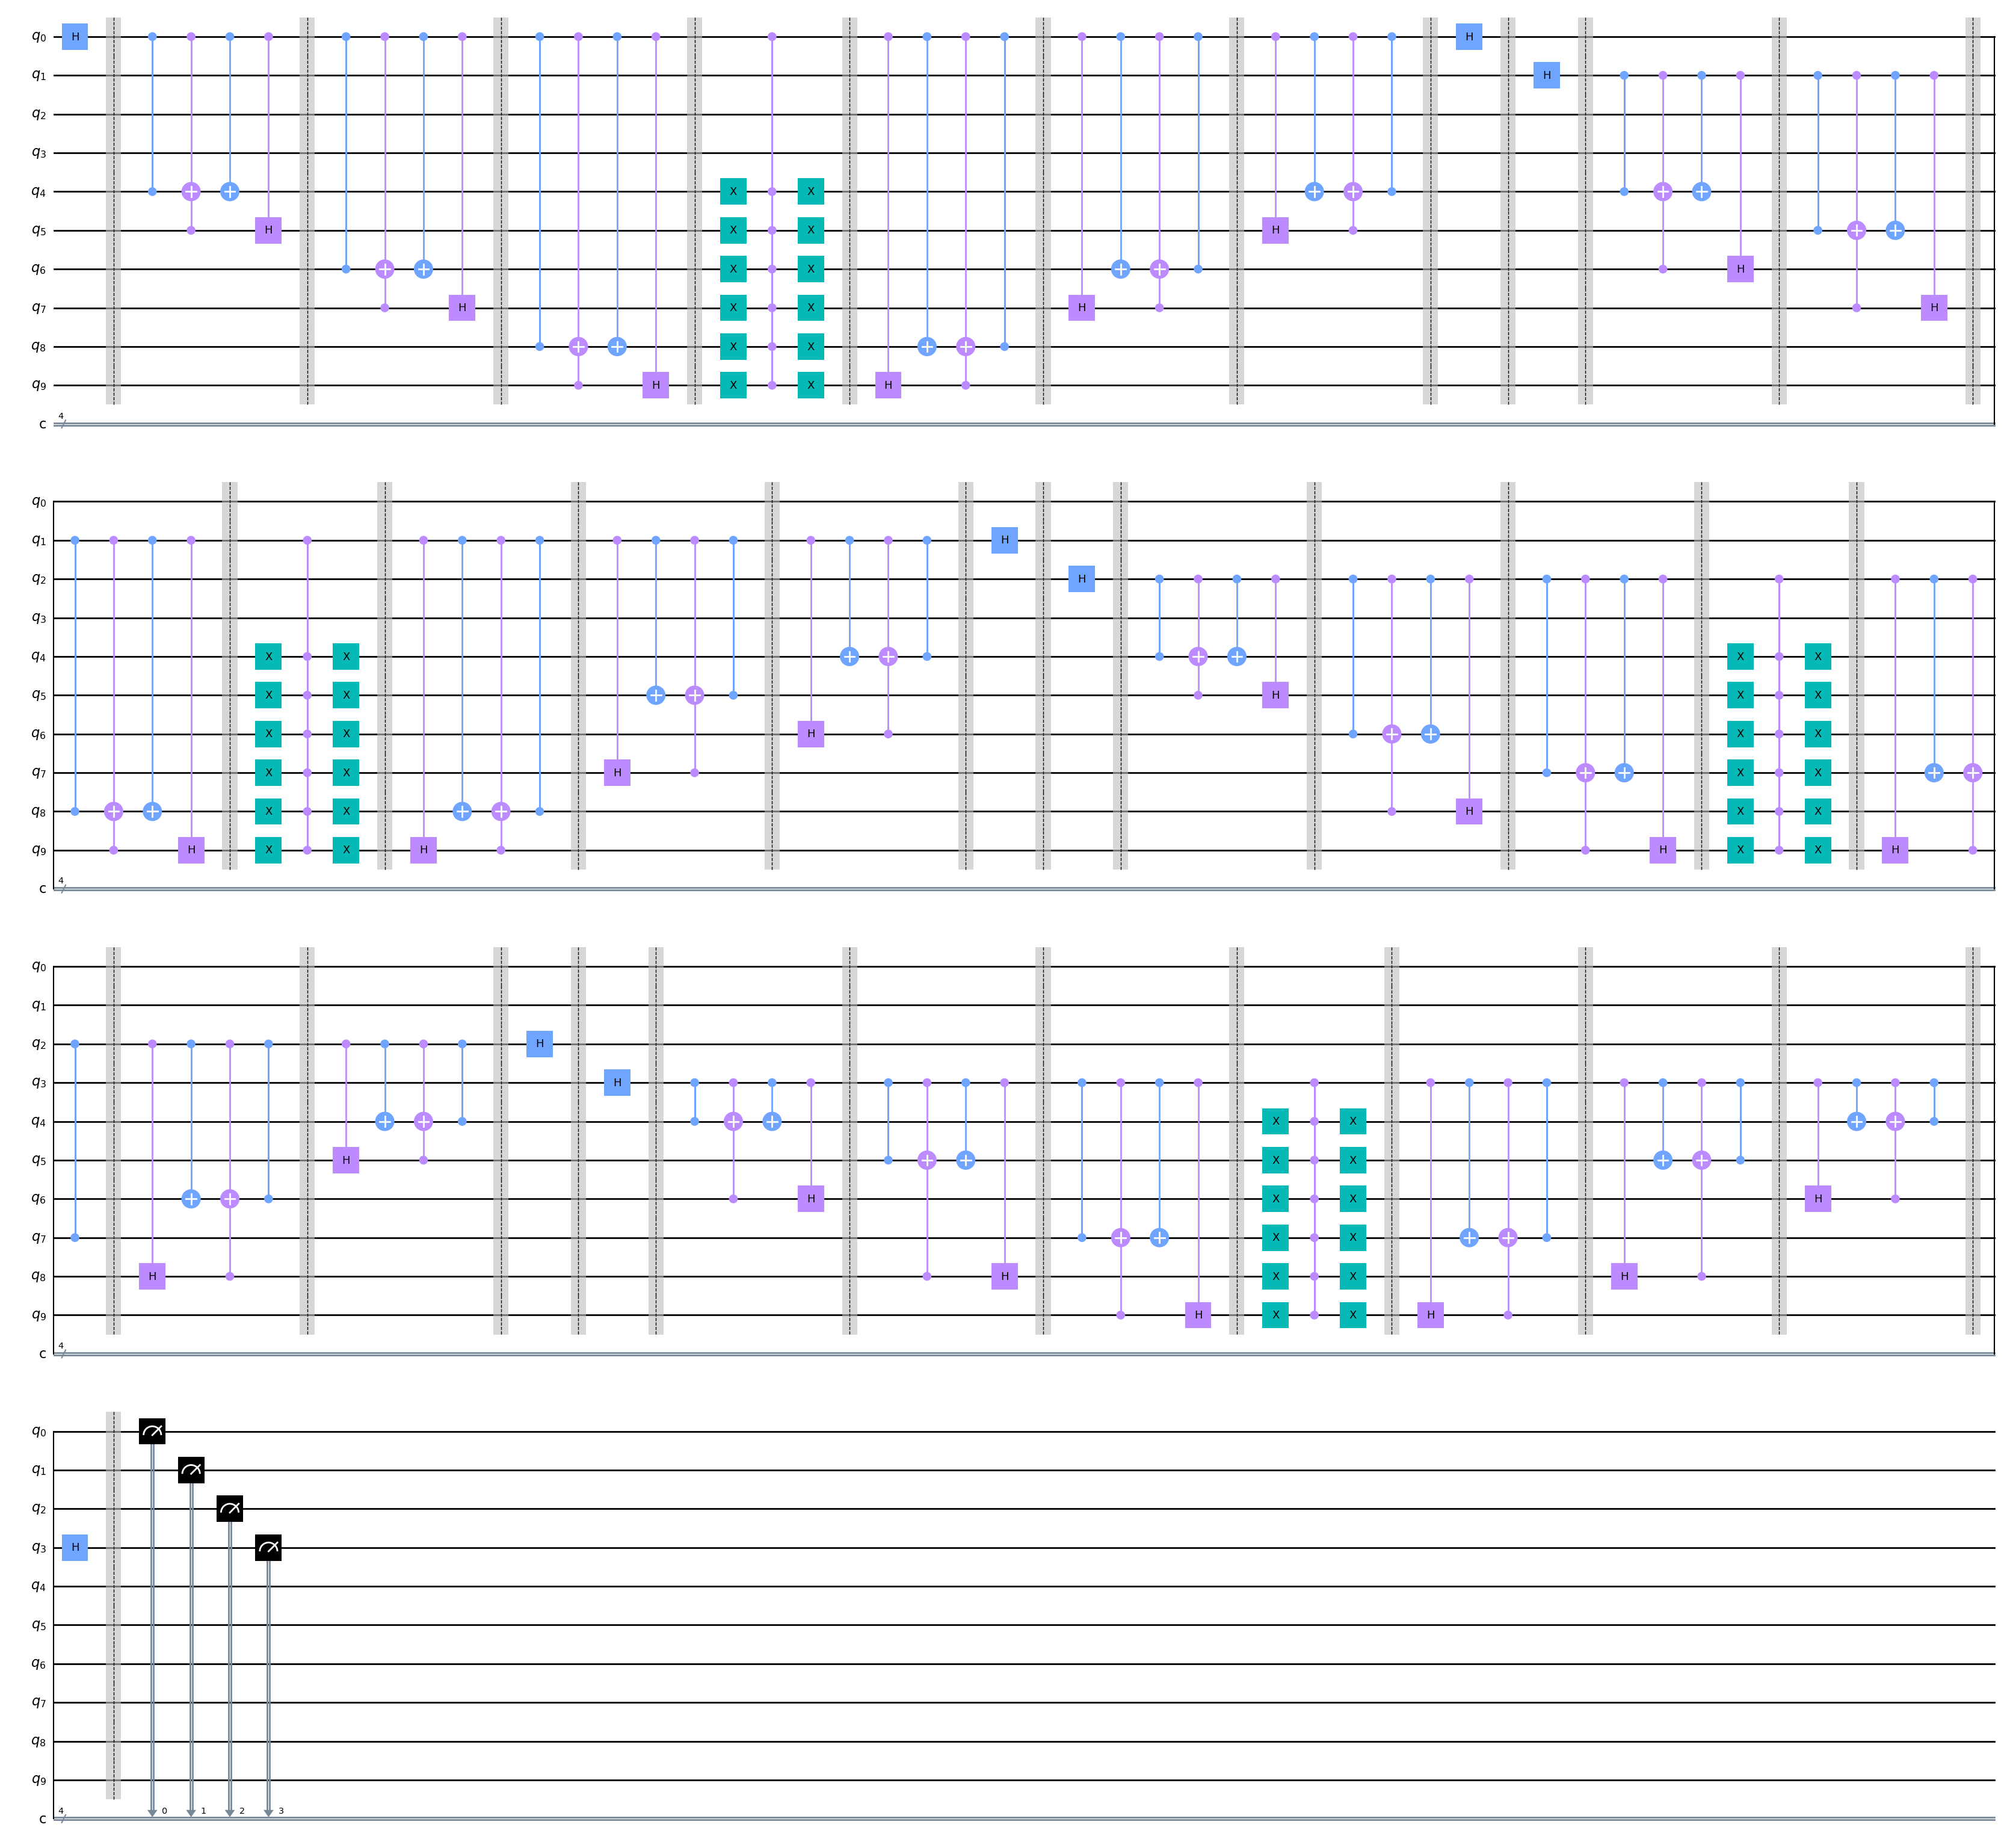

In [55]:
qcs[4].draw(output='mpl', fold=50)

In [62]:
from qiskit.visualization import circuit_drawer

for i in range(2,4):
    fig = circuit_drawer(qcs[i], output='mpl', fold=60)
    fig.savefig(f'qcs{i}_for_6.pdf', bbox_inches='tight')

In [202]:
state1, _ = convert([[1, 3], [2, 4], [5, 6]])
state2, _ = convert([[1, 2], [3, 5], [4, 6]])
state3, _ = convert([[1, 2], [3, 4], [5, 6]])
state4, _ = convert([[1, 3], [2, 5], [4, 6]])
state5, _ = convert([[1, 4], [2, 5], [3, 6]])
print('the similarity of state 1 and 3 is ', np.abs(np.dot(state1, np.conjugate(state3))))
print('the similarity of state 1 and 2 is ', np.abs(np.dot(state1, np.conjugate(state2))))
print('the similarity of state 2 and 3 is ', np.abs(np.dot(state2, np.conjugate(state3))))
print('the similarity of state 2 and 4 is ', np.abs(np.dot(state2, np.conjugate(state4))))
print('the similarity of state 3 and 4 is ', np.abs(np.dot(state3, np.conjugate(state4))))
print('the similarity of state 1 and 4 is ', np.abs(np.dot(state1, np.conjugate(state4))))
print('the similarity of state 1 and 5 is ', np.abs(np.dot(state1, np.conjugate(state5))))
print('the similarity of state 2 and 5 is ', np.abs(np.dot(state2, np.conjugate(state5))))
print('the similarity of state 3 and 5 is ', np.abs(np.dot(state3, np.conjugate(state5))))
print('the similarity of state 4 and 5 is ', np.abs(np.dot(state4, np.conjugate(state5))))

the similarity of state 1 and 3 is  0.4999999999999999
the similarity of state 1 and 2 is  0.24999999999999994
the similarity of state 2 and 3 is  0.4999999999999999
the similarity of state 2 and 4 is  0.4999999999999999
the similarity of state 3 and 4 is  0.24999999999999994
the similarity of state 1 and 4 is  0.4999999999999999
the similarity of state 1 and 5 is  0.24999999999999994
the similarity of state 2 and 5 is  0.24999999999999994
the similarity of state 3 and 5 is  0.24999999999999994
the similarity of state 4 and 5 is  0.4999999999999999


In [206]:
state1, _ = convert([[1, 2], [3, 4], [5, 6], [7, 8]])
state2, _ = convert([[1, 4], [2, 6], [3, 7], [5, 8]])
print('the similarity of state 1 and 2 is ', np.abs(np.dot(state1, np.conjugate(state2))))

the similarity of state 1 and 2 is  0.125


In [231]:
test = QuantumCircuit(2)
test.h(0)

simulator = Aer.get_backend('statevector_simulator')
job = execute(test, simulator, shots=1)
result = job.result()
state = np.asarray(result.get_statevector())
print('the state is ', state)

the state is  [0.70710678+0.j 0.70710678+0.j 0.        +0.j 0.        +0.j]


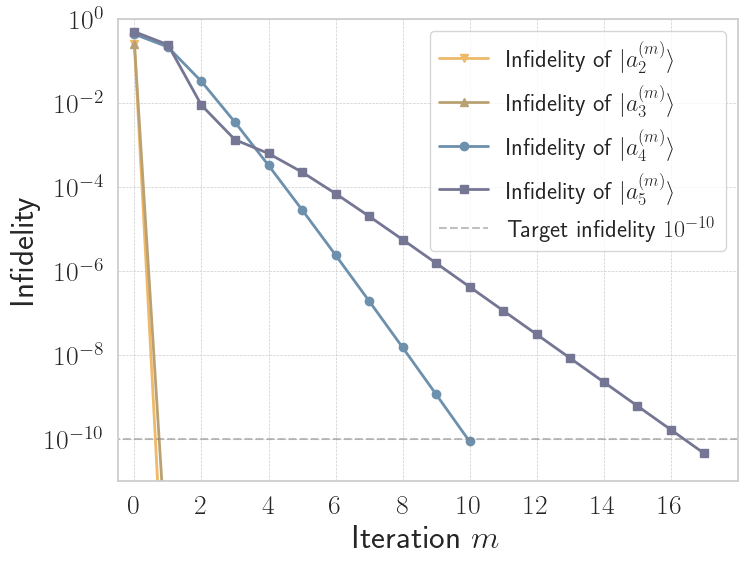

In [498]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)

infidelity_1 = [0.2500000000000001, 2.220446049250313e-16]
infidelity_2 = [0.2500000000000001, 4.440892098500626e-14]
infidelity_3 = [
    0.4375, 0.21632653061224472, 0.032745591939546737, 0.0035073492143944396,
    0.0003304978314260243, 2.9006752374383105e-05, 2.4239163451955648e-06,
    1.9526726169338815e-07, 1.528921178550746e-08, 1.170216368251431e-09,
    8.791745109704152e-11
]
infidelity_4 = [
    0.5000000000000001, 0.24567219152854525, 0.00890866044479377,
    0.0013436829780456572, 0.0006328665662863608, 0.00022800916711374075,
    7.037324716474558e-05, 2.0260898503599023e-05, 5.649841727461968e-06,
    1.5520483271913577e-06, 4.233354915506027e-07, 1.1507707875502149e-07,
    3.123103931024218e-08, 8.46925440889379e-09, 2.2958386303173484e-09,
    6.222418136303531e-10, 1.6863177521031503e-10, 4.5698111961200993e-11
]
max_length = max(len(infidelity_1), len(infidelity_2), len(infidelity_3), len(infidelity_4))

plt.figure(figsize=(8, 6))  # 宽 10，高 6 英寸

plt.plot(range(len(infidelity_1)), infidelity_1, marker='v',label=r'Infidelity of $|a_2^{(m)}\rangle$', color='#eeb969',lw=2)
plt.plot(range(len(infidelity_2)), infidelity_2, marker='^' ,label=r'Infidelity of $|a_3^{(m)}\rangle$', color='#baa173', lw=2)
plt.plot(range(len(infidelity_3)), infidelity_3, marker='o', label=r'Infidelity of $|a_4^{(m)}\rangle$', color='#6d90ad', lw=2)
plt.plot(range(len(infidelity_4)), infidelity_4, marker='s', label=r'Infidelity of $|a_5^{(m)}\rangle$', color='#757693', lw=2)
plt.plot(range(-1, max_length+1), [1e-10] * (max_length+2), linestyle='--', color='grey', alpha=0.5, lw=1.5, label='Target infidelity $10^{-10}$')  # 添加目标收敛线

# 创建图像

# 对 y 轴使用对数尺度（更好地展示收敛行为）
plt.yscale('log')
plt.ylim(1e-11, 1)  # 设置 y 轴范围
plt.xlim(-0.5, max_length)  # 设置 x 轴范围
plt.yticks([1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1], fontsize=20)
plt.xticks(np.arange(0, max_length, 2), fontsize=20)
plt.xlabel(r'Iteration $m$', fontsize=24)
plt.ylabel('Infidelity', fontsize=24)
# 添加图例
plt.legend(fontsize=17.5)

# 添加网格增强可读性
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# 显示图像
plt.savefig('6_infidelity_convergence.pdf', bbox_inches='tight', dpi=300)
plt.show()

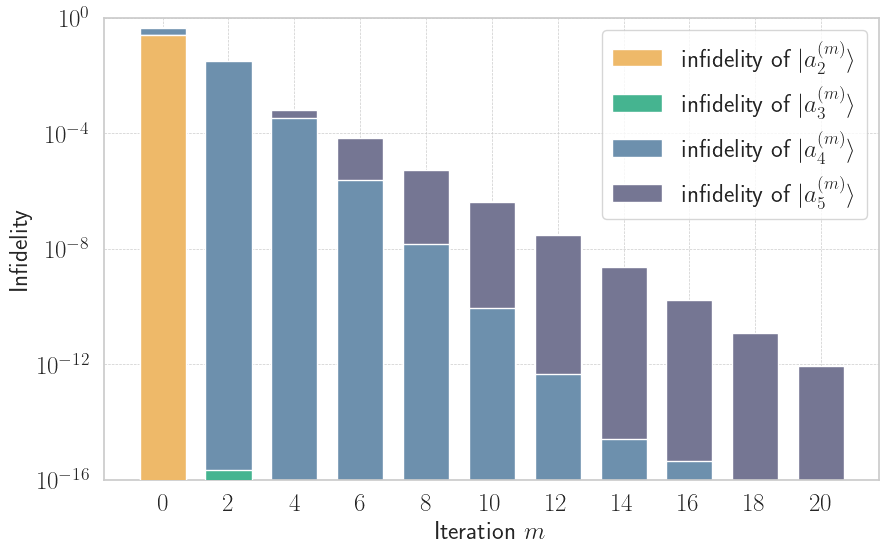

In [454]:
# now 柱状图
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
infidelity_1 = [0.2500000000000001, 2.220446049250313e-16, 0.0, 0.0, 0.0, 0.0, -8.881784197001252e-16, 2.220446049250313e-16, -4.440892098500626e-16, 0.0, -4.440892098500626e-16, -4.440892098500626e-16, 0.0, -4.440892098500626e-16, -8.881784197001252e-16, 4.440892098500626e-16, -4.440892098500626e-16, -8.881784197001252e-16, 2.220446049250313e-16, 0.0, 0.0]
infidelity_2 = [0.2500000000000001, -4.440892098500626e-16, 2.220446049250313e-16, -4.440892098500626e-16, 0.0, 0.0, 0.0, 0.0, 0.0, -4.440892098500626e-16, 0.0, 0.0, 0.0, 0.0, 2.220446049250313e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 2.220446049250313e-16]
infidelity_3 = [0.4375, 0.21632653061224472, 0.032745591939546737, 0.0035073492143944396, 0.0003304978314260243, 2.9006752374383105e-05, 2.4239163451955648e-06, 1.9526726169338815e-07, 1.528921178550746e-08, 1.170216368251431e-09, 8.791745109704152e-11, 6.503686478254167e-12, 4.745093207247919e-13, 3.419486915845482e-14, 2.6645352591003757e-15, 0.0, 4.440892098500626e-16, 0.0, 0.0, 0.0, 0.0]
infidelity_4 = [0.5000000000000001, 0.24567219152854525, 0.00890866044479377, 0.0013436829780456572, 0.0006328665662863608, 0.00022800916711374075, 7.037324716474558e-05, 2.0260898503599023e-05, 5.649841727461968e-06, 1.5520483271913577e-06, 4.233354915506027e-07, 1.1507707875502149e-07, 3.123103931024218e-08, 8.46925440889379e-09, 2.2958386303173484e-09, 6.222418136303531e-10, 1.6863177521031503e-10, 4.5698111961200993e-11, 1.2383871705878846e-11, 3.355760114231998e-12, 9.090506125630782e-13]
max_length = max(len(infidelity_1), len(infidelity_2), len(infidelity_3), len(infidelity_4))

# choose the 0,2,4,6,... item
infidelity_1 = infidelity_1[::2]
infidelity_2 = infidelity_2[::2]
infidelity_3 = infidelity_3[::2]
infidelity_4 = infidelity_4[::2]

# if a value is less than 1e-15, set all value behind it to 0
for i in range(len(infidelity_1)):
    if infidelity_1[i] < 1e-15:
        infidelity_1 = infidelity_1[:i+1] + [0] * (len(infidelity_1) - i-1)
        break
for i in range(len(infidelity_2)):
    if infidelity_2[i] < 1e-15:
        infidelity_2 = infidelity_2[:i+1] + [0] * (len(infidelity_2) - i-1)
        break
for i in range(len(infidelity_3)):
    if infidelity_3[i] < 1e-15:
        infidelity_3 = infidelity_3[:i+1] + [0] * (len(infidelity_3) - i-1)
        break
for i in range(len(infidelity_4)):
    if infidelity_4[i] < 1e-15:
        infidelity_4 = infidelity_4[:i+1] + [0] * (len(infidelity_4) - i-1)
        break

# bar chart
x = np.arange(0, max_length, 2)  # the label locations
width = 1.4  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x, infidelity_1, width, label=r'infidelity of $|a_2^{(m)}\rangle$', color='#eeb969', zorder=4)
rects2 = ax.bar(x, infidelity_2, width, label=r'infidelity of $|a_3^{(m)}\rangle$', color='#45b490', zorder=3)
rects3 = ax.bar(x, infidelity_3, width, label=r'infidelity of $|a_4^{(m)}\rangle$', color='#6d90ad', zorder=2)
rects4 = ax.bar(x, infidelity_4, width, label=r'infidelity of $|a_5^{(m)}\rangle$', color='#757693', zorder=1)


ax.set_xlabel('Iteration $m$', fontsize=18)
ax.set_ylabel('Infidelity', fontsize=18)
ax.set_yscale('log')
ax.set_ylim(1e-16, 1)  # 设置 y 轴范围
ax.set_xticks(x)
ax.set_yticks([1e-16, 1e-12, 1e-8, 1e-4,1])
ax.tick_params(labelsize=18)  # 一次性设置所有刻度字体大小
ax.legend(fontsize=18)

# 添加网格增强可读性
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# save the figure
plt.savefig('6_infidelity_convergence_bar.pdf', bbox_inches='tight', dpi=300)

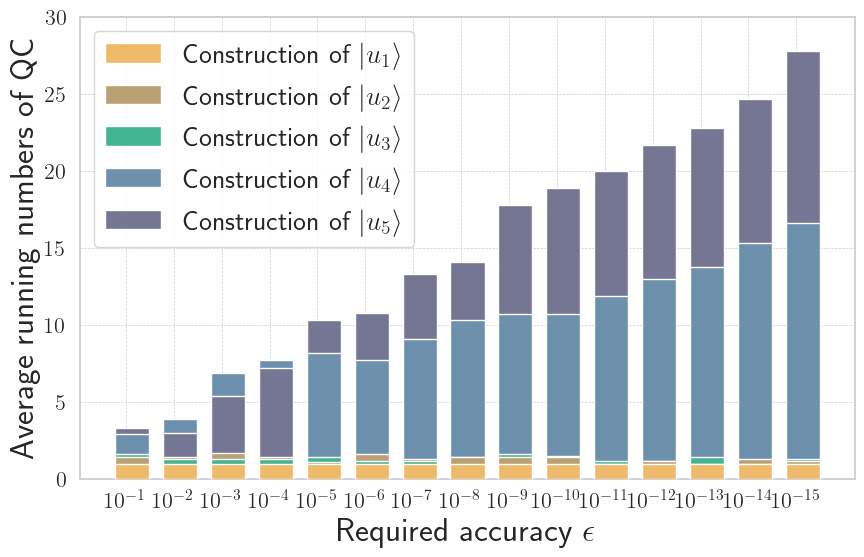

In [499]:
# now 柱状图
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)

running_number_1 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
running_number_2 = [1.4, 1.4, 1.7, 1.4, 1.1, 1.6, 1.3, 1.4, 1.4, 1.4, 1.0, 1.2, 1.0, 1.3, 1.2]
running_number_3 = [1.6, 1.3, 1.3, 1.3, 1.4, 1.2, 1.2, 1.4, 1.6, 1.5, 1.2, 1.2, 1.4, 1.0, 1.3]
running_number_4 = [2.9, 3.9, 6.9, 7.7, 8.2, 7.7, 9.1, 10.3, 10.7, 10.7, 11.9, 13.0, 13.8, 15.3, 16.6]
running_number_5 = [3.3, 3.0, 5.4, 7.2, 10.3, 10.8, 13.3, 14.1, 17.8, 18.9, 20.0, 21.7, 22.8, 24.7, 27.8]
max_length = max(len(running_number_1), len(running_number_2), len(running_number_3), len(running_number_4), len(running_number_5))

# bar chart
x = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
width = [i for i in x]  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(x)):
    xi = x[i]
    yi_list = [running_number_1[i], running_number_2[i], running_number_3[i], running_number_4[i], running_number_5[i]]
    yi_list_sorted = sorted(range(len(yi_list)), key=lambda k: yi_list[k])
    index_range = [-1 for _ in range(len(yi_list))]
    for j in range(len(yi_list)):
        index_range[yi_list_sorted[j]] = len(yi_list) - j
    wi = width[i] * 1.35  # 设置柱子的宽度为 x 的 80%
    if i == 0:
        ax.bar(xi, yi_list[0], width=wi, label=r'Construction of $|u_1\rangle$', color='#eeb969', zorder=index_range[0])
        ax.bar(xi, yi_list[1], width=wi, label=r'Construction of $|u_2\rangle$', color='#baa173', zorder=index_range[1])
        ax.bar(xi, yi_list[2], width=wi, label=r'Construction of $|u_3\rangle$', color='#45b490', zorder=index_range[2])
        ax.bar(xi, yi_list[3], width=wi, label=r'Construction of $|u_4\rangle$', color='#6d90ad', zorder=index_range[3])
        ax.bar(xi, yi_list[4], width=wi, label=r'Construction of $|u_5\rangle$', color='#757693', zorder=index_range[4])
    else:
        ax.bar(xi, yi_list[0], width=wi, color='#eeb969', zorder=index_range[0])
        ax.bar(xi, yi_list[1], width=wi, color='#baa173', zorder=index_range[1])
        ax.bar(xi, yi_list[2], width=wi, color='#45b490', zorder=index_range[2])
        ax.bar(xi, yi_list[3], width=wi, color='#6d90ad', zorder=index_range[3])
        ax.bar(xi, yi_list[4], width=wi, color='#757693', zorder=index_range[4])
# rects1 = ax.bar(x, running_number_1, width, label=r'circuit running times of $|a_1^{(m)}\rangle$', color='#eeb969', zorder=5)
# rects2 = ax.bar(x, running_number_2, width, label=r'circuit running times of $|a_2^{(m)}\rangle$', color='#baa173', zorder=4)
# rects3 = ax.bar(x, running_number_3, width, label=r'circuit running times of $|a_3^{(m)}\rangle$', color='#45b490', zorder=3)
# rects4 = ax.bar(x, running_number_4, width, label=r'circuit running times of $|a_4^{(m)}\rangle$', color='#6d90ad', zorder=2)
# rects5 = ax.bar(x, running_number_5, width, label=r'circuit running times of $|a_5^{(m)}\rangle$', color='#757693', zorder=1)


ax.set_xlabel('Required accuracy $\epsilon$', fontsize=24)
ax.set_ylabel('Average running numbers of QC', fontsize=24)
ax.set_xscale('log')
ax.set_ylim(0,30)  # 设置 y 轴范围
ax.set_xticks(x)
# reverse the x axis
ax.invert_xaxis()
ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
ax.tick_params(labelsize=16)  # 一次性设置所有刻度字体大小
ax.legend(fontsize=20)

# 添加网格增强可读性
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# save the figure
plt.savefig('6_running_number_bar.pdf', bbox_inches='tight', dpi=300)